**RQ2**
---

**What is the relationship between physiological responses (GSR and respiration rate) and the self-reported experience of awe?**

- H2.1: There will be a positive correlation between GSR and self-reported awe levels, indicating that higher GSR reflects greater emotional arousal associated with awe.
    - **ToDo:** Analyse GSR measures correlation to Awe-S scores
- H2.2: Changes in respiration rate will correlate with self-reported awe, suggesting that a lower respiration rate is indicative of a deeper awe experience. *(Not considered here: Additionally, the combination of increased GSR and decreased respiration rate will serve as a strong predictor of high self-reported awe.)*
    - **ToDo:** Analyse Respiration measures correlation to Awe-S scores
    - **ToDo:** consider second aspect? Or delete
- H2.3: In awe-inspiring scenes with a transition from a narrow to a vast view, this transition phase elicits significantly higher physiological responses than the rest of the scene due to the dramatic change and surprise
    - **ToDo:** Analyse 20 sec of measures in NtV transition phase versus other time

Get from data: 
- AWE-S scores
- GSR measures (SCR, SCL)
- Respiration measure (resp_rate)
- SCR, SCL and resp_rate in narrow to vast (NtV) transition

**Boferroni correction for multiple comparisons** \
For Hypothesis 2 we have \
H2.1: 2 \
H2.2: 1 \
H2.3: 3 \
= 6

In [1]:
bonferroniCorrection = 6

**Import Statements**

In [1]:
import os
import json
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import pearsonr, spearmanr, shapiro, linregress, rankdata, anderson
from statsmodels.stats.diagnostic import lilliefors
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

**Load the data**

In [2]:
data_path = "../data"
physiological_file = "IterativeDenoising/ALL_physiological_measures.csv"
denoising_log_file = "IterativeDenoising/ALL_denoising_log.csv"
questionnaire_file = "processed data/combined_questionnaire_dataLikert.csv"

output_file = "processed data/Step3_RQ2_output_combined_awe_physiological_data.csv"
output_pdf = "plots/H2_1_correlations_AWES_physio.pdf"

conditions = ['AbstractAwe', 'Borealis', 'Church', 'Forest', 'Mountain', 'Neutral1', 'Neutral3', 'Space', 'Underwater', 'Waterfall']
#in some cases, the sensor channels were switched so in the log files breath and gsr data are also switched.
switch_ids = {'1111', '7878', '4545', '5656', '7575', '8585', '9898', '7373', '3929', '9191', '2343', '99991', '99992', '99993', '99994', '99995', '99996', '99997', '99998', '99999', '88881'}

physiological_data = pd.read_csv(physiological_file)
denoising_log = pd.read_csv(denoising_log_file, header=None, names=["file", "sensor", "iterations", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
questionnaire_data = pd.read_csv(questionnaire_file)

---

**Preprocessing: get scl, scr and resp_rate in a 20sec frame of the NtV event**

In [3]:
def time_to_seconds(time_str):
    h, m, s, ms = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s) + int(ms) / 1000

# get number of denoising iterations
def get_iterations(file_path, sensor, denoising_log):
    log_entry = denoising_log[
        (denoising_log["file"] == file_path) & 
        (denoising_log["sensor"] == sensor)
    ]
    if not log_entry.empty:
        # sum iterations where 'y' is marked
        iteration_columns = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
        iterations = log_entry[iteration_columns].iloc[0].apply(lambda x: 1 if x == "y" else 0).sum()
    else:
        iterations = 1
    
    return iterations

# denoise GSR data
def denoise_gsr(gsr_data):
    window_size = 10
    gsr_cleaned = np.convolve(gsr_data, np.ones(window_size)/window_size, mode='valid')
    gsr_cleaned = np.convolve(gsr_cleaned, np.ones(window_size)/window_size, mode='valid')
    return gsr_cleaned

# denoise breath data
def denoise_breath(breath_data):
    breath_cleaned = nk.rsp_clean(breath_data, sampling_rate=10, method='biosppy')
    return breath_cleaned

# apply denoising based on log
def apply_denoising(data, sensor_type, iterations):
    for _ in range(iterations):
        if sensor_type == "gsr":
            data = denoise_gsr(data)
        elif sensor_type == "breath":
            data = denoise_breath(data)
    return data

def load_json_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data["Items"]

rows = []
for _, row in physiological_data.iterrows():
    file_path = row['file']
    participant_id = row['participant_id']
    condition = next((cond for cond in conditions if cond in file_path), None)
    
    awe_s_score_series = questionnaire_data.loc[
        (questionnaire_data['participantID'] == participant_id) & 
        (questionnaire_data[f"AWE-S_Total_{condition}"].notnull()), 
        f"AWE-S_Total_{condition}"
    ] if condition else pd.Series()

    awe_s_score = awe_s_score_series.values[0] if not awe_s_score_series.empty else np.nan
    
    file_path_norm = os.path.normpath(file_path)
    data = load_json_data(file_path_norm)
    
    if participant_id in switch_ids:
        # multiply with 0.0015 to convert to gsr range 
        gsr_data = [float(item["breathData"].replace(",", ".")) * 0.0015 for item in data]
        breath_data = [float(item["gsrData"].replace(",", ".")) for item in data]
    else:
        gsr_data = [float(item["gsrData"].replace(",", ".")) for item in data]
        breath_data = [float(item["breathData"].replace(",", ".")) for item in data]
    
    timestamps = np.array([time_to_seconds(item['time']) for item in data])
    
    gsr_iterations = get_iterations(file_path_norm, "gsr", denoising_log)
    breath_iterations = get_iterations(file_path_norm, "breath", denoising_log)
    
    gsr_cleaned = apply_denoising(gsr_data, "gsr", gsr_iterations)
    breath_cleaned = apply_denoising(breath_data, "breath", breath_iterations)
    
    eda_signals, eda_info = nk.eda_process(gsr_cleaned, sampling_rate=10)
    rsp_signals, rsp_info = nk.rsp_process(breath_cleaned, sampling_rate=10)

    #ntv 
    ntv_event = next((item for item in data if item.get("specialEvent") == "NtV"), None)
    if ntv_event:
        ntv_time = time_to_seconds(ntv_event['time'])
        time_diff = np.abs(timestamps - ntv_time)
        closest_idx = np.argmin(time_diff)
        
        valid_indices = eda_signals.index[(eda_signals.index >= closest_idx - 100) & (eda_signals.index <= closest_idx + 100)]
        
        scl_ntv = eda_signals.loc[valid_indices, 'EDA_Tonic'].mean() if not valid_indices.empty else np.nan
        scr_ntv = sum(1 for onset in eda_info['SCR_Onsets'] if not np.isnan(onset) and (closest_idx - 100 <= onset <= closest_idx + 100))
        resp_rate_ntv = rsp_signals.loc[valid_indices, 'RSP_Rate'].mean() if not valid_indices.empty else np.nan
    else:
        scl_ntv, scr_ntv, resp_rate_ntv = np.nan, np.nan, np.nan

    #baseline
    start_event = next((item for item in data if item.get("specialEvent") == "StartScene"), None)
    if start_event:
        start_time = time_to_seconds(start_event['time'])
        timestamps_trimmed = timestamps[:len(eda_signals)]
        valid_indices_start = np.where(timestamps_trimmed <= start_time)[0]
        
        if len(valid_indices_start) > 0:
            valid_indices_start = eda_signals.index[valid_indices_start]

            scl_start = eda_signals.loc[valid_indices_start, 'EDA_Tonic'].mean() if not valid_indices_start.empty else np.nan
            scr_start = sum(1 for onset in eda_info['SCR_Onsets'] if not np.isnan(onset) and (onset in valid_indices_start))
            resp_rate_start = rsp_signals.loc[valid_indices_start, 'RSP_Rate'].mean() if not valid_indices_start.empty else np.nan
        else:
            scl_start, scr_start, resp_rate_start = np.nan, np.nan, np.nan
    else:
        scl_start, scr_start, resp_rate_start = np.nan, np.nan, np.nan

    #normal
    if start_event:
        start_time = time_to_seconds(start_event['time'])
        timestamps_trimmed = timestamps[:len(eda_signals)]
        valid_indices_start = np.where(timestamps_trimmed >= start_time)[0]
        if len(valid_indices_start) > 0:
            valid_indices_start = eda_signals.index[valid_indices_start]

            scl = eda_signals.loc[valid_indices_start, 'EDA_Tonic'].mean() if not valid_indices_start.empty else np.nan
            scr = sum(1 for onset in eda_info['SCR_Onsets'] if not np.isnan(onset) and (onset in valid_indices_start))
            resp_rate = rsp_signals.loc[valid_indices_start, 'RSP_Rate'].mean() if not valid_indices_start.empty else np.nan
        else:
            scl, scr, resp_rate = np.nan, np.nan, np.nan
    else:
        scl, scr, resp_rate = np.nan, np.nan, np.nan
    
    rows.append({
        "participant_id": participant_id,
        "condition": condition,
        "AWE-S": awe_s_score,
        "scl": scl,
        "scr": scr,
        "resp_rate": resp_rate,
        "scl_NtV": scl_ntv,
        "scr_NtV": scr_ntv,
        "resp_rate_NtV": resp_rate_ntv,
        "scl_start": scl_start,
        "scr_start": scr_start,
        "resp_rate_start": resp_rate_start,
        "scl_minus_baseline": scl-scl_start,
        "scr_minus_baseline": scr-scr_start,
        "resp_rate_minus_baseline": resp_rate-resp_rate_start,
        "scl_ntv_minus_baseline": scl_ntv-scl_start,
        "scr_ntv_minus_baseline": scr_ntv-scr_start,
        "resp_rate_ntv_minus_baseline": resp_rate_ntv-resp_rate_start
    })

result_df = pd.DataFrame(rows)
result_df.to_csv(output_file, index=False)

C:\Users\steininger\AppData\Local\Programs\Python\Python313\Lib\site-packages\neurokit2\eda\eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
C:\Users\steininger\AppData\Local\Programs\Python\Python313\Lib\site-packages\neurokit2\eda\eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
C:\Users\steininger\AppData\Local\Programs\Python\Python313\Lib\site-packages\neurokit2\eda\eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
C:\Users\steininger\AppData\Local\Programs\Python\Python313\Lib\site-packages\neurokit2\eda\eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
C:\Users\steininger\AppData\Local\Programs\Python\Python313\

KeyboardInterrupt: 

---

<span style='color: red;'>Warnings in the previous code block are fine.</span>\
The warnings happen if there are no scr peaks detected from the NeutoKit library or the signal is too short to calculate scl or  respiration rate. In this case the scr value will be set to 0 and the scl and respiration rate to nan.

---

Before doing the analysis we excluded the following participants:\
4444: all (several corrupted files)\
75: Abstract Awe\
7373: Mountain

**Hypotheses 2.1-3**
---


All three sub-hypotheses need the same analysis.

H2.1: do correlation analysis
- SCR vs AWE-S
- SCL vs AWE-S

H2.2: do correlation analysis
- resp_rate vs AWE-S

H2.3: do correlation analysis
- SCR_NtV vs AWE-S
- SCL_NtV vs AWE-S
- resp_rate_NtV vs AWE-S



Correlation Results:


Normality tests:
  Shapiro Wilk (SCR): W = 0.920, p = 0.000
  Shapiro Wilk (AWE-S): W = 0.978, p = 0.000
  Kolmogorov-Smirnov (Lilliefors) (SCR): D = 0.146, p = 0.001
  Kolmogorov-Smirnov (Lilliefors) (AWE-S): D = 0.065, p = 0.001
  N: 602
SCR vs AWE-S
  Correlation method: Spearman
 r(600) = -0.008, p = 1.000 


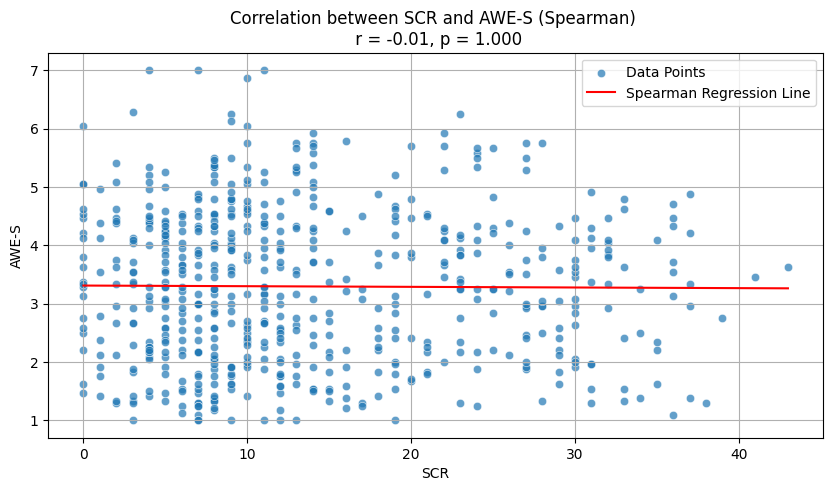


Normality tests:
  Shapiro Wilk (SCR minus baseline): W = 0.925, p = 0.000
  Shapiro Wilk (AWE-S): W = 0.978, p = 0.000
  Kolmogorov-Smirnov (Lilliefors) (SCR minus baseline): D = 0.135, p = 0.001
  Kolmogorov-Smirnov (Lilliefors) (AWE-S): D = 0.065, p = 0.001
  N: 602
SCR minus baseline vs AWE-S
  Correlation method: Spearman
 r(600) = -0.008, p = 1.000 


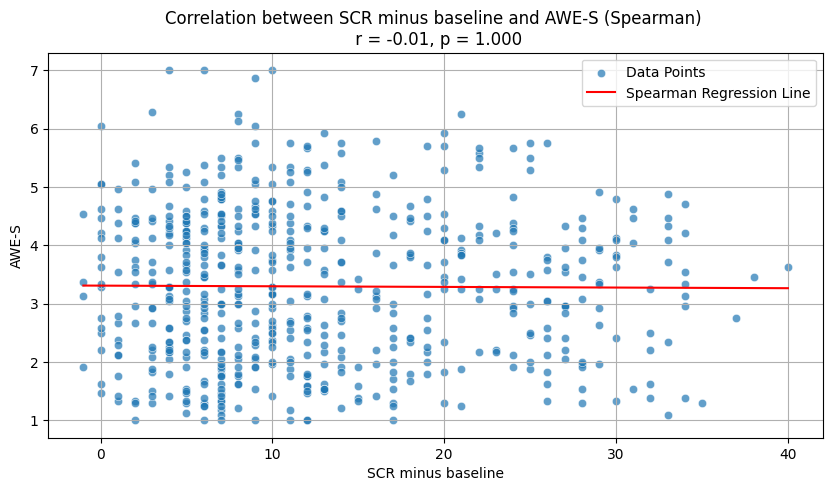


Normality tests:
  Shapiro Wilk (SCL): W = 0.760, p = 0.000
  Shapiro Wilk (AWE-S): W = 0.978, p = 0.000
  Kolmogorov-Smirnov (Lilliefors) (SCL): D = 0.226, p = 0.001
  Kolmogorov-Smirnov (Lilliefors) (AWE-S): D = 0.065, p = 0.001
  N: 602
SCL vs AWE-S
  Correlation method: Spearman
 r(600) = 0.078, p = 0.343 


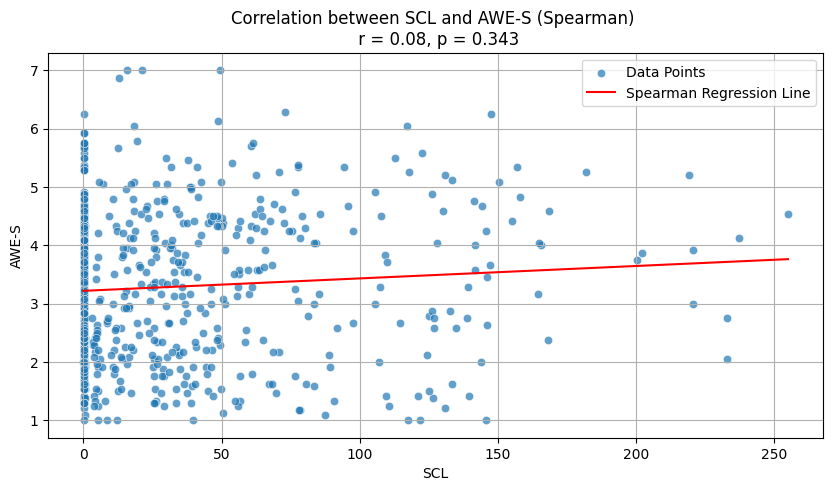


Normality tests:
  Shapiro Wilk (SCL minus baseline): W = 0.759, p = 0.000
  Shapiro Wilk (AWE-S): W = 0.978, p = 0.000
  Kolmogorov-Smirnov (Lilliefors) (SCL minus baseline): D = 0.232, p = 0.001
  Kolmogorov-Smirnov (Lilliefors) (AWE-S): D = 0.065, p = 0.001
  N: 602
SCL minus baseline vs AWE-S
  Correlation method: Spearman
 r(600) = -0.071, p = 0.495 


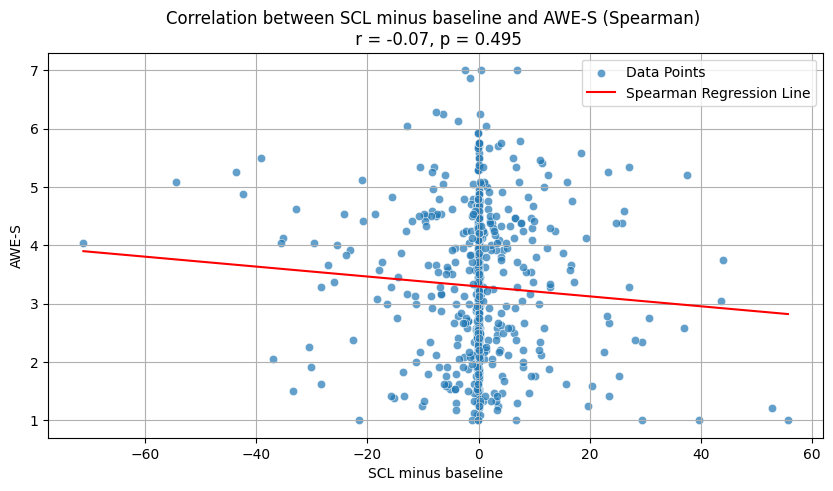


Normality tests:
  Shapiro Wilk (Respiration Rate): W = 0.963, p = 0.000
  Shapiro Wilk (AWE-S): W = 0.978, p = 0.000
  Kolmogorov-Smirnov (Lilliefors) (Respiration Rate): D = 0.090, p = 0.001
  Kolmogorov-Smirnov (Lilliefors) (AWE-S): D = 0.065, p = 0.001
  N: 602
Respiration Rate vs AWE-S
  Correlation method: Spearman
 r(600) = 0.013, p = 1.000 


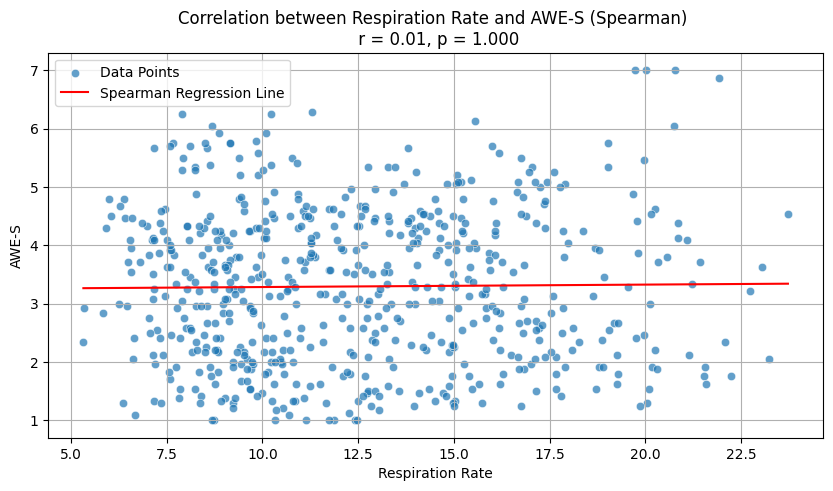


Normality tests:
  Shapiro Wilk (Respiration Rate minus baseline): W = 0.945, p = 0.000
  Shapiro Wilk (AWE-S): W = 0.978, p = 0.000
  Kolmogorov-Smirnov (Lilliefors) (Respiration Rate minus baseline): D = 0.114, p = 0.001
  Kolmogorov-Smirnov (Lilliefors) (AWE-S): D = 0.065, p = 0.001
  N: 602
Respiration Rate minus baseline vs AWE-S
  Correlation method: Spearman
 r(600) = -0.020, p = 1.000 


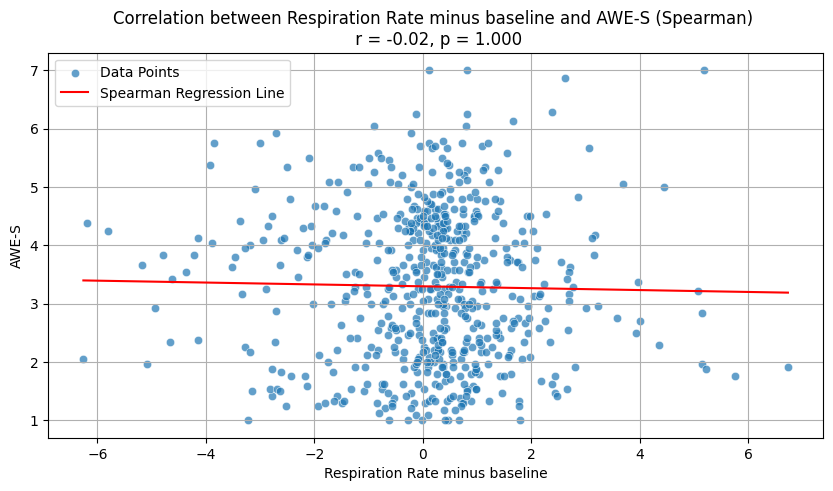


Normality tests:
  Shapiro Wilk (SCR_NtV): W = 0.916, p = 0.000
  Shapiro Wilk (AWE-S): W = 0.990, p = 0.002
  Kolmogorov-Smirnov (Lilliefors) (SCR_NtV): D = 0.203, p = 0.001
  Kolmogorov-Smirnov (Lilliefors) (AWE-S): D = 0.044, p = 0.040
  N: 475
SCR_NtV vs AWE-S
  Correlation method: Spearman
 r(473) = 0.025, p = 1.000 


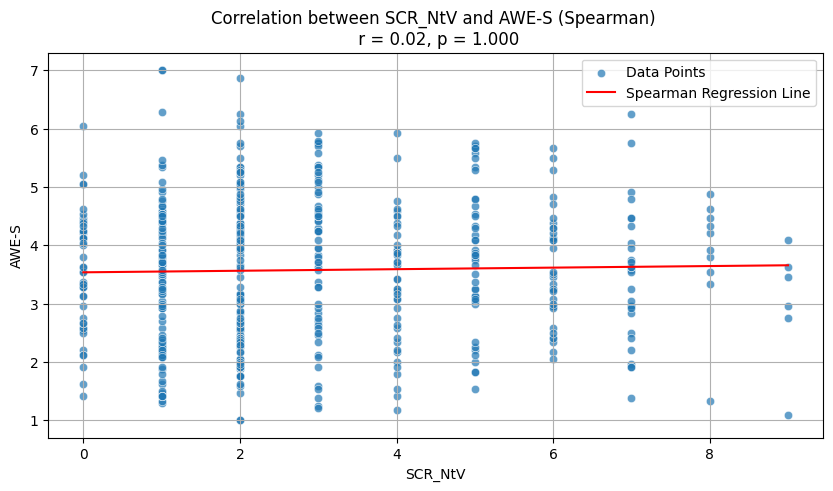


Normality tests:
  Shapiro Wilk (SCR_NtV minus baseline): W = 0.945, p = 0.000
  Shapiro Wilk (AWE-S): W = 0.990, p = 0.002
  Kolmogorov-Smirnov (Lilliefors) (SCR_NtV minus baseline): D = 0.168, p = 0.001
  Kolmogorov-Smirnov (Lilliefors) (AWE-S): D = 0.044, p = 0.040
  N: 475
SCR_NtV minus baseline vs AWE-S
  Correlation method: Spearman
 r(473) = 0.026, p = 1.000 


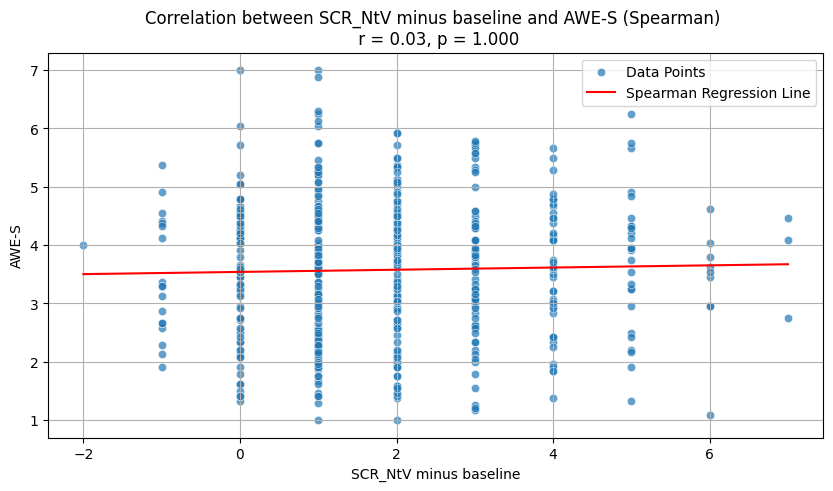


Normality tests:
  Shapiro Wilk (SCL_NtV): W = 0.762, p = 0.000
  Shapiro Wilk (AWE-S): W = 0.990, p = 0.002
  Kolmogorov-Smirnov (Lilliefors) (SCL_NtV): D = 0.226, p = 0.001
  Kolmogorov-Smirnov (Lilliefors) (AWE-S): D = 0.044, p = 0.040
  N: 475
SCL_NtV vs AWE-S
  Correlation method: Spearman
 r(473) = 0.077, p = 0.567 


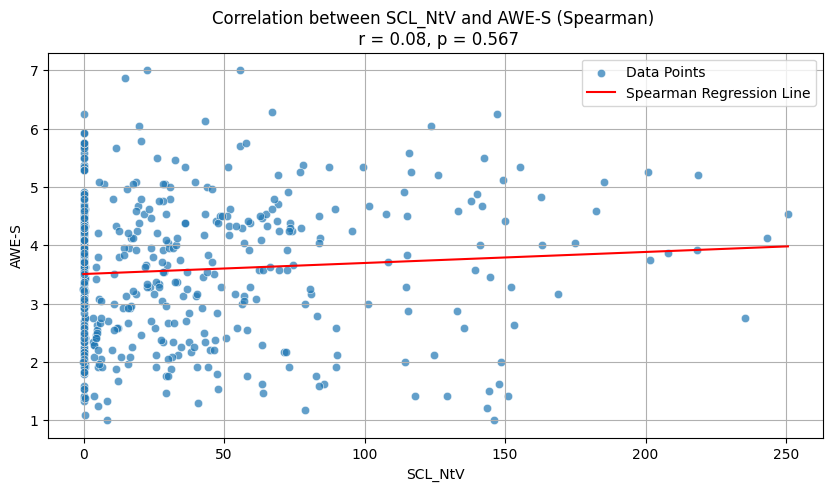


Normality tests:
  Shapiro Wilk (SCL_NtV minus baseline): W = 0.754, p = 0.000
  Shapiro Wilk (AWE-S): W = 0.990, p = 0.002
  Kolmogorov-Smirnov (Lilliefors) (SCL_NtV minus baseline): D = 0.244, p = 0.001
  Kolmogorov-Smirnov (Lilliefors) (AWE-S): D = 0.044, p = 0.040
  N: 475
SCL_NtV minus baseline vs AWE-S
  Correlation method: Spearman
 r(473) = -0.049, p = 1.000 


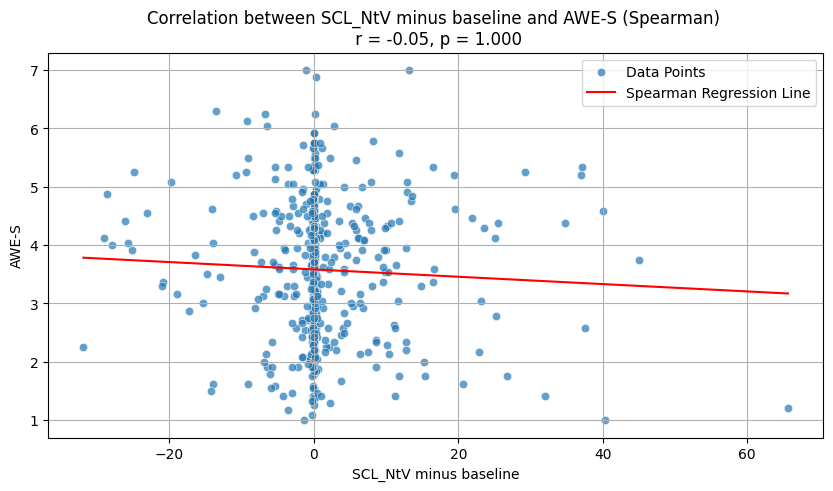


Normality tests:
  Shapiro Wilk (Respiration Rate_NtV): W = 0.983, p = 0.000
  Shapiro Wilk (AWE-S): W = 0.990, p = 0.002
  Kolmogorov-Smirnov (Lilliefors) (Respiration Rate_NtV): D = 0.065, p = 0.001
  Kolmogorov-Smirnov (Lilliefors) (AWE-S): D = 0.044, p = 0.040
  N: 475
Respiration Rate_NtV vs AWE-S
  Correlation method: Spearman
 r(473) = -0.002, p = 1.000 


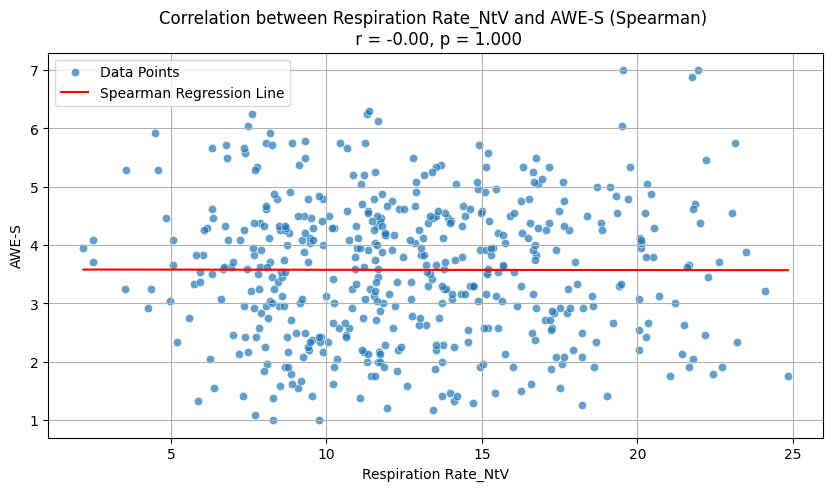


Normality tests:
  Shapiro Wilk (Respiration Rate_NtV minus baseline): W = 0.980, p = 0.000
  Shapiro Wilk (AWE-S): W = 0.990, p = 0.002
  Kolmogorov-Smirnov (Lilliefors) (Respiration Rate_NtV minus baseline): D = 0.057, p = 0.002
  Kolmogorov-Smirnov (Lilliefors) (AWE-S): D = 0.044, p = 0.040
  N: 475
Respiration Rate_NtV minus baseline vs AWE-S
  Correlation method: Spearman
 r(473) = -0.016, p = 1.000 


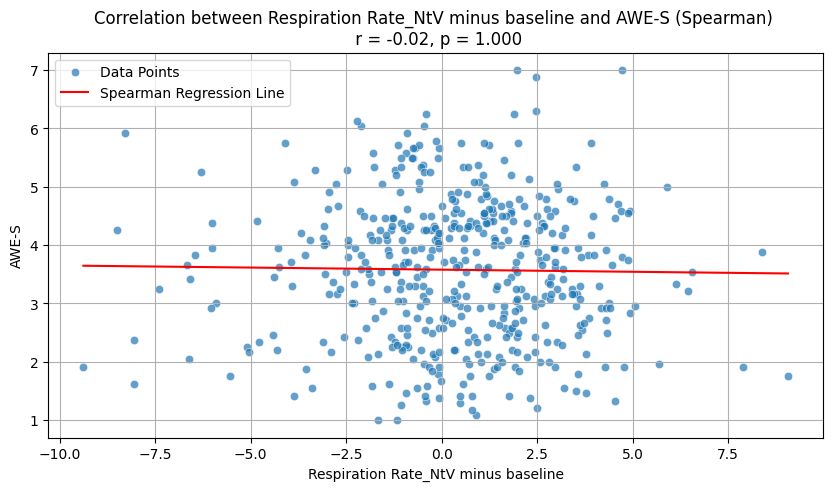

In [4]:
def format_p_value(p_value):
    p_value = p_value * bonferroniCorrection
    if p_value > 1:
        p_value = 1
    return "p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"

data = pd.read_csv('processed data/Step3_RQ2_output_combined_awe_physiological_data.csv')

with PdfPages(output_pdf) as pdf:
    metrics = [
        ('scr', 'SCR'),
        ('scr_minus_baseline', 'SCR minus baseline'),
        ('scl', 'SCL'),
        ('scl_minus_baseline', 'SCL minus baseline'),
        ('resp_rate', 'Respiration Rate'),
        ('resp_rate_minus_baseline', 'Respiration Rate minus baseline'),
        ('scr_NtV', 'SCR_NtV'),
        ('scr_ntv_minus_baseline', 'SCR_NtV minus baseline'),
        ('scl_NtV', 'SCL_NtV'),
        ('scl_ntv_minus_baseline', 'SCL_NtV minus baseline'),
        ('resp_rate_NtV', 'Respiration Rate_NtV'),
        ('resp_rate_ntv_minus_baseline', 'Respiration Rate_NtV minus baseline')
    ]

    print("Correlation Results:\n")
    for metric, label in metrics:
        df_valid = data[[metric, 'AWE-S']].dropna()

        if df_valid.empty:
            print(f"\nSkipping {label} due to lack of valid data.")
            continue

        # Normality tests
        SW_is_normal_metric, SW_p_metric = shapiro(df_valid[metric])
        SW_is_normal_awe, SW_p_awe = shapiro(df_valid['AWE-S'])

        KSL_is_normal_metric, KSL_p_metric = lilliefors(df_valid[metric])
        KSL_is_normal_awe, KSL_p_awe = lilliefors(df_valid['AWE-S'])

        # choose correlation method based on shapiro (both SW and KSL are <.05 for all condition so it actually doesnt matter)
        if SW_p_metric > 0.05:
            corr_method = "Pearson"
            corr, pval = pearsonr(df_valid[metric], df_valid['AWE-S'])
        else:
            corr_method = "Spearman"
            corr, pval = pearsonr(df_valid[metric], df_valid['AWE-S'])

        pval_formatted = format_p_value(pval)
        n = len(df_valid)

        # Print statistics
        print("\nNormality tests:")
        print(f"  Shapiro Wilk ({label}): W = {SW_is_normal_metric:.3f}, p = {SW_p_metric:.3f}")
        print(f"  Shapiro Wilk (AWE-S): W = {SW_is_normal_awe:.3f}, p = {SW_p_awe:.3f}")
        print(f"  Kolmogorov-Smirnov (Lilliefors) ({label}): D = {KSL_is_normal_metric:.3f}, p = {KSL_p_metric:.3f}")
        print(f"  Kolmogorov-Smirnov (Lilliefors) (AWE-S): D = {KSL_is_normal_awe:.3f}, p = {KSL_p_awe:.3f}")
        print(f"  N: {n}")
        print(f"{label} vs AWE-S")
        print(f"  Correlation method: {corr_method}")
        print(f"\033[1m r({n-2}) = {corr:.3f}, {pval_formatted} \033[0m")
